Retrieves images from "full_imgs" and stores each VOI separately in "train_imgs". Retrieves spreadsheet listing VOIs and stores them in text file. Requires data-retrieval to be run first.

In [70]:
import config
import copy
import csv
import helper_fxns as hf
import importlib
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import requests
import sys
import time
import transforms as tr
import voi_methods as vm
%matplotlib inline

In [69]:
importlib.reload(config)
importlib.reload(hf)
importlib.reload(tr)
importlib.reload(vm)
C = config.Config()

In [46]:
final_size = C.dims

voi_df_art = pd.read_csv(C.art_voi_path)
voi_df_ven = pd.read_csv(C.ven_voi_path)
voi_df_eq = pd.read_csv(C.eq_voi_path)

In [6]:
def augment_img(img, final_dims, voi, num_samples, translate=None, add_reflections=False):
    """For rescaling an img to final_dims while scaling to make sure the image contains the voi."""
    
    x1 = voi[0]
    x2 = voi[1]
    y1 = voi[2]
    y2 = voi[3]
    z1 = voi[4]
    z2 = voi[5]
    dx = x2 - x1
    dy = y2 - y1
    dz = z2 - z1
    
    buffer1 = 0.7
    buffer2 = 0.9
    scale_ratios = [final_dims[0]/dx, final_dims[1]/dy, final_dims[2]/dz]

    aug_imgs = []
    
    for _ in range(num_samples):
        scales = [random.uniform(scale_ratios[0]*buffer1, scale_ratios[0]*buffer2),
                 random.uniform(scale_ratios[1]*buffer1, scale_ratios[1]*buffer2),
                 random.uniform(scale_ratios[2]*buffer1, scale_ratios[2]*buffer2)]
        
        angle = random.randint(0, 359)

        temp_img = tr.scale3d(img, scales)
        temp_img = tr.rotate(temp_img, angle)
        
        if translate is not None:
            trans = [random.randint(-translate[0], translate[0]),
                     random.randint(-translate[1], translate[1]),
                     random.randint(-translate[2], translate[2])]
        else:
            trans = [0,0,0]
        
        flip = [random.choice([-1, 1]), random.choice([-1, 1]), random.choice([-1, 1])]

        crops = [temp_img.shape[i] - final_dims[i] for i in range(3)]
    
        for i in range(3):
            assert crops[i]>=0

        #temp_img = add_noise(temp_img)

        temp_img = temp_img[crops[0]//2 *flip[0] + trans[0] : -crops[0]//2 *flip[0] + trans[0] : flip[0],
                            crops[1]//2 *flip[1] + trans[1] : -crops[1]//2 *flip[1] + trans[1] : flip[1],
                            crops[2]//2 *flip[2] + trans[2] : -crops[2]//2 *flip[2] + trans[2] : flip[2], :]
        
        aug_imgs.append(temp_img)
        
        if add_reflections:
            aug_imgs.append(tr.generate_reflected_img(temp_img))
    
    return aug_imgs

In [40]:
classes_to_include = ['cyst', 'hcc', 'hemangioma']#, 'cholangio', 'colorectal']#, 'fnh']

"""if os.path.exists(C.aug_dir):
    print("Warning: path", C.aug_dir, "already exists.")
else:
    os.makedirs(C.aug_dir)"""
for cls in classes_to_include:
    if not os.path.exists(C.orig_dir + cls):
        os.makedirs(C.orig_dir + cls)
    if not os.path.exists(C.aug_dir + cls):
        os.makedirs(C.aug_dir + cls)
    if not os.path.exists(C.crops_dir + cls):
        os.makedirs(C.crops_dir + cls)

Generate VOI cutouts

In [41]:
small_vois = {}
small_vois = vm.extract_vois(os.listdir(C.full_img_dir), small_vois, classes_to_include, C, voi_df_art, voi_df_ven, voi_df_eq)

............................................................................
286.8612561225891


In [42]:
with open(C.small_voi_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in small_vois.items():
        writer.writerow([key, value])

Generate scaled images

In [43]:
t = time.time()

for cls in classes_to_include:#os.listdir(C.crops_dir):
    for fn in os.listdir(C.crops_dir + cls):
        img = np.load(C.crops_dir + cls + "\\" + fn)
        unaug_img = vm.resize_img(img, C.dims, small_vois[fn[:-4]])
        np.save(C.orig_dir + cls + "\\" + fn, unaug_img)
        
print(time.time()-t)

7.334055185317993


In [ ]:
small_vois = extract_vois(["12042703.npy"], small_vois)

In [ ]:
t = time.time()

for cls in os.listdir(C.crops_dir):
    for fn in ['12042703_0.npy']:#os.listdir(C.crops_dir + cls):
        img = np.load(C.crops_dir + cls + "\\" + fn)
        unaug_img = vm.resize_img(img, C.dims, small_vois[fn[:-4]])
        np.save(C.orig_dir + cls + "\\" + fn, unaug_img)
        
print(time.time()-t)

Generate augmented images

In [44]:
t = time.time()

for cls in classes_to_include:#os.listdir(C.crops_dir):
    for file_num, fn in enumerate(os.listdir(C.crops_dir + cls)):
        img = np.load(C.crops_dir + cls + "\\" + fn)
        aug_img = augment_img(img, C.dims, small_vois[fn[:-4]], num_samples=50, translate=[2,2,1])
        
        for x, sample in enumerate(aug_img):
            np.save(C.aug_dir + cls + "\\" + fn[:-4] + "_" + str(x), sample)
            
        if file_num % 20 == 0:
            print(".", end="")

print("")
print(time.time()-t)

........
710.9386665821075


Generate reflected images

In [100]:
importlib.reload(tr)

<module 'transforms' from 'C:\\Users\\Clinton\\Documents\\voi-classifier\\transforms.py'>

In [ ]:
for cls in os.listdir(C.aug_dir):#classes_to_include:
    for img_fn in os.listdir(C.aug_dir + cls):
        if "refl" in img_fn:
            os.remove(C.aug_dir + cls + "\\" + img_fn)

In [ ]:
for cls in os.listdir(C.aug_dir):#classes_to_include:
    for img_fn in os.listdir(C.aug_dir + cls):
        if "refl" not in img_fn:
            img = np.load(C.aug_dir + cls + "\\" + img_fn)
            aug_img = tr.generate_reflected_img(img)
            np.save(C.aug_dir + cls + "\\" + img_fn[:-4] + "-refl", aug_img)

In [ ]:
dims_df = pd.read_csv(C.dims_df_path)

dims_df[dims_df["AccNum"] == accnum]

voi_df_art[voi_df_art["Filename"] == accnum+".npy"]

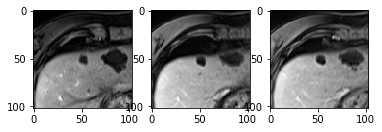

In [71]:
cls = "cyst"
accnum = "13112385"
img = np.load(C.crops_dir + cls + "\\" + accnum + "_0.npy")
hf.plot_section_auto(img)

In [112]:
img = generate_reflected_imgs(img)

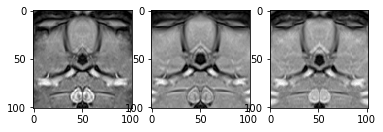

In [113]:
hf.plot_section_auto(img)

In [72]:
img.shape

(36, 36, 12, 3)

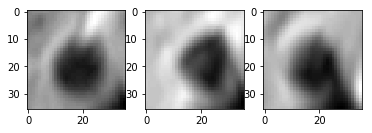

In [71]:
cls = "cyst"
accnum = "12042703"
img = np.load(C.orig_dir + cls + "\\" + accnum + "_0.npy")
hf.plot_section_auto(img)

In [ ]:
cls = "cyst"
accnum = "12042703"
img = np.load(C.aug_dir + cls + "\\" + accnum + "_0_0.npy")
hf.plot_section_auto(img)

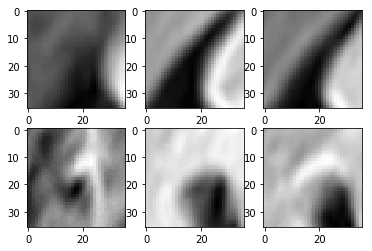

In [17]:
hf.plot_section_scan(img, 0.9)

img_fn = "E100529980.npy"
img = np.load(C.full_img_dir+"\\"+img_fn)
hf.plot_section(img, voi_df[voi_df["Filename"] == img_fn].iloc[0], pad=0)
#art_vois = voi_df_art[(voi_df_art["Filename"] == img_fn) & (voi_df_art["cls"].isin(classes_to_include))]

#img = np.load("orig_imgs\\cyst\\E100529980_1.npy")
#plt.imshow(img[:,:,5,0], cmap='gray')

hf.augment(pad_img, C.dims, translate=[1,1,0], exceed_ratio=0.9, num_samples=1)